In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import pickle


In [2]:
pkl_file = open('./JoinedData.pkl','rb')
df = pickle.load(pkl_file)
pkl_file.close()


In [3]:
df.head()

,Year,Quarter,Month,DayofMonth,FlightDate,Origin,CRSDepTime,DepTime,CRSArrTime,ArrTime,...,precipMM,pressure,WindGustKmph,visibility,weatherCode,tempF,WindChillF,winddirDegree,humidity,time
0,2016.0,1.0,1.0,1.0,2016-01-01,SEA,745.0,741.0,1602.0,1610.0,...,0.0,1030,8,10,113,34,29,108,65,800
1,2016.0,1.0,1.0,1.0,2016-01-01,SEA,820.0,821.0,1204.0,1237.0,...,0.0,1030,8,10,113,34,29,108,65,800
2,2016.0,1.0,1.0,1.0,2016-01-01,SEA,724.0,759.0,946.0,1010.0,...,0.0,1030,8,10,113,34,29,108,65,800
3,2016.0,1.0,1.0,1.0,2016-01-01,SEA,759.0,754.0,1143.0,1138.0,...,0.0,1030,8,10,113,34,29,108,65,800
4,2016.0,1.0,1.0,1.0,2016-01-01,SEA,738.0,740.0,1351.0,1401.0,...,0.0,1030,8,10,113,34,29,108,65,800


In [4]:
df.columns


Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'FlightDate', 'Origin',
       'CRSDepTime', 'DepTime', 'CRSArrTime', 'ArrTime', 'ArrDelayMinutes',
       'ArrDel15', 'NearestDepTime', 'totalSnow_cm', 'date', 'windspeedKmph',
       'DewPointF', 'cloudcover', 'precipMM', 'pressure', 'WindGustKmph',
       'visibility', 'weatherCode', 'tempF', 'WindChillF', 'winddirDegree',
       'humidity', 'time'],
      dtype='object')

# Logistic Regression

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import confusion_matrix 

In [6]:
df.dropna(how='any',inplace=True)
df.drop(columns=['FlightDate','date','Origin','ArrTime','ArrDelayMinutes','CRSArrTime','NearestDepTime'],inplace=True)
X = df.loc[:, df.columns != 'ArrDel15']
y = df.loc[:, df.columns == 'ArrDel15']

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,test_size=0.25)

In [7]:
df.shape

(1851115, 21)

In [8]:
X_train.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'CRSDepTime', 'DepTime',
       'totalSnow_cm', 'windspeedKmph', 'DewPointF', 'cloudcover', 'precipMM',
       'pressure', 'WindGustKmph', 'visibility', 'weatherCode', 'tempF',
       'WindChillF', 'winddirDegree', 'humidity', 'time'],
      dtype='object')

In [29]:
classifier =  LogisticRegression(random_state=42,max_iter=10000)
classifier.fit(X_train,y_train)

/home/mahesh/miniconda3/envs/icell/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [30]:
y_pred = classifier.predict(X_test)

In [35]:
print('Accuracy of logistic regression classifier on test set: {:.3f}'.format(classifier.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.800


In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.80      1.00      0.89    365730
         1.0       0.89      0.05      0.09     97049

    accuracy                           0.80    462779
   macro avg       0.85      0.52      0.49    462779
weighted avg       0.82      0.80      0.72    462779



In [ ]:

cm = confusion_matrix(y_test, y_pred) 
  
print ("Confusion Matrix : \n", cm) 

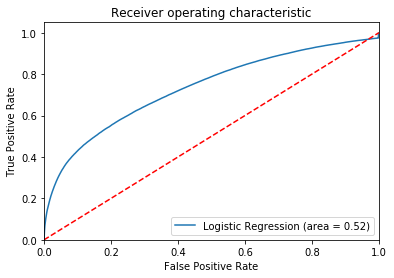

In [33]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, classifier.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# Decision Tree Classifier

In [9]:
from sklearn.tree import DecisionTreeClassifier

In [10]:
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state = 2) 
X_train_res, y_train_res = sm.fit_sample(X_train, y_train) 

Using TensorFlow backend.


In [11]:
print(X_train.shape)
print(X_train_res.shape)
print(y_train.shape)
print(y_train_res.shape)

(1388336, 20)
(2194874, 20)
(1388336, 1)
(2194874, 1)


In [12]:
print(len(y[y_train==1]),len(y[y_train==0]))

1851115 1851115


In [21]:
classifier_tree  = DecisionTreeClassifier(max_depth = 100,random_state = 0)
classifier_tree.fit(X_train_res,y_train_res)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=100, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [22]:
y_pred = classifier_tree.predict(X_test)

In [23]:
classifier_tree.get_depth()

56

In [24]:
score = classifier_tree.score(X_test,y_test)
print(score)

0.8557583641435761


In [25]:
importances = pd.DataFrame({'Feature':X_train.columns,'Importance':np.round(classifier_tree.feature_importances_,3)})
importances = importances.sort_values('Importance',ascending=False)
importances

,Feature,Importance
4,CRSDepTime,0.255
5,DepTime,0.234
1,Quarter,0.139
0,Year,0.090
2,Month,0.067
17,winddirDegree,0.026
10,precipMM,0.026
3,DayofMonth,0.023
11,pressure,0.019
18,humidity,0.019


In [28]:
cm = confusion_matrix(y_test, y_pred) 
  
print ("Confusion Matrix : \n", cm) 

Confusion Matrix : 
 [[328724  37006]
 [ 29746  67303]]


In [ ]:
# depth 20
print(classification_report(y_test, y_pred))

In [ ]:
# depth 30
print(classification_report(y_test, y_pred))

In [ ]:
# depth 50

print(classification_report(y_test, y_pred))

In [29]:
#After SMOTE
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.92      0.90      0.91    365730
         1.0       0.65      0.69      0.67     97049

    accuracy                           0.86    462779
   macro avg       0.78      0.80      0.79    462779
weighted avg       0.86      0.86      0.86    462779



In [ ]:
delayed.shape

In [ ]:
logit_roc_auc = roc_auc_score(y_test, classifier_tree.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, classifier_tree.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# XGBoost Classifier

In [13]:
from sklearn.ensemble import GradientBoostingClassifier

In [18]:
# D_train = xgb.DMatrix(X_train_res.iloc[:,:].values, label=y_train_res.iloc[:].values)
# D_test = xgb.DMatrix(X_test.iloc[:,:].values, label=y_test.iloc[:].values)

In [19]:
# param = {
#     'eta': 0.3, 
#     'max_depth': 3,  
#     'objective': 'multi:softprob',  
#     'num_class': 3} 

# steps = 20  # The number of training iterations

In [24]:
model = GradientBoostingClassifier(max_depth=5)
model.fit(X_train_res,y_train_res)

/home/mahesh/miniconda3/envs/icell/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [25]:
y_pred = model.predict(X_test)

In [26]:
#After XGBoost
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.90      0.98      0.94    365730
         1.0       0.89      0.59      0.71     97049

    accuracy                           0.90    462779
   macro avg       0.89      0.78      0.82    462779
weighted avg       0.90      0.90      0.89    462779



In [27]:
cm = confusion_matrix(y_test, y_pred) 
  
print ("Confusion Matrix : \n", cm) 

Confusion Matrix : 
 [[358393   7337]
 [ 39878  57171]]


# Random Forest Classifier

In [13]:
from sklearn.ensemble import RandomForestClassifier

In [14]:
rfc_model = RandomForestClassifier(random_state=42,n_jobs=3)
rfc_model.fit(X_train_res,y_train_res)

/home/mahesh/miniconda3/envs/icell/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=3,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [15]:
y_pred = rfc_model.predict(X_test)

In [16]:
#After Random Forest Classification
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.89      0.95      0.92    365730
         1.0       0.74      0.58      0.65     97049

    accuracy                           0.87    462779
   macro avg       0.82      0.76      0.79    462779
weighted avg       0.86      0.87      0.86    462779



In [17]:
cm = confusion_matrix(y_test, y_pred) 
  
print ("Confusion Matrix : \n", cm) 

Confusion Matrix : 
 [[345763  19967]
 [ 40601  56448]]
